<a href="https://colab.research.google.com/github/ILLATICI/EnGeL-Theory/blob/main/ammonite_lab/ammonite_sutures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🐚 AMMONITE FOCUS: Mapping η → Geometry...
✅ Graph saved: ammonite_lab/ammonite_focus_J.png
   Max D: 1.6102
   Min D: 1.3283
   Golden D (η≈0.618): 1.5162 (Target: ~1.4 for strong shell)


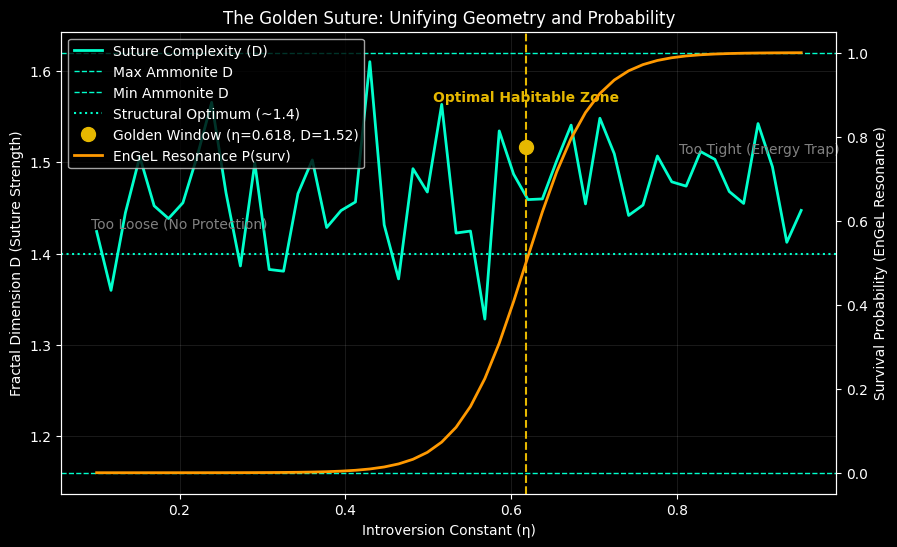

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress

# --- SETTINGS ---
OUTPUT_DIR = "ammonite_lab"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def get_b_from_eta(eta):
    eta = max(eta, 0.001)
    return np.log(1.0 / eta) / (np.pi / 2.0)

def generate_fbm(n, H):
    freqs = np.fft.fftfreq(n)
    freqs = np.abs(freqs)
    # To get the RuntimeWarning, comment out the next line
    freqs[0] = 1e-6  # Avoid divide by zero
    scale = freqs ** - (H + 0.5)
    fourier = scale * np.exp(1j * 2 * np.pi * np.random.rand(n))
    fbm = np.real(np.fft.ifft(fourier))
    return fbm

def generate_spiral(b, turns=10, points=5000, H=0.5, sigma=2.2):
    theta = np.linspace(0, turns * 2 * np.pi, points)
    noise_r = generate_fbm(points, H)
    noise_r = noise_r - np.mean(noise_r)
    if np.std(noise_r) > 0:
        noise_r /= np.std(noise_r)
    noise_theta = generate_fbm(points, H)
    noise_theta = noise_theta - np.mean(noise_theta)
    if np.std(noise_theta) > 0:
        noise_theta /= np.std(noise_theta)
    r = np.exp(b * theta + sigma * noise_r)
    theta_pert = theta + sigma * noise_theta
    r = np.clip(r, 1e-10, 1e10)
    x = r * np.cos(theta_pert)
    y = r * np.sin(theta_pert)
    return x, y

def higuchi_fd(x, y, k_max=50):
    N = len(x)
    k_values = np.arange(1, k_max + 1)
    log_k = np.log(k_values)
    log_L = []
    for k in k_values:
        Lm = []
        for m in range(1, k + 1):
            idx = np.arange(m - 1, N, k)
            if len(idx) < 2:
                continue
            diffs_x = np.diff(x[idx])
            diffs_y = np.diff(y[idx])
            abs_diffs = np.sqrt(diffs_x**2 + diffs_y**2)
            sum_abs = np.sum(abs_diffs)
            num_intervals = len(idx) - 1
            L_m_k = ((N - 1) / (num_intervals * k)) * sum_abs
            Lm.append(L_m_k)
        if Lm:
            L_k = np.mean(Lm)
            log_L.append(np.log(L_k))
    if len(log_L) < 2:
        return 1.0
    slope = linregress(log_k[:len(log_L)], log_L).slope
    return 1 - slope

def run_ammonite_focus():
    print("🐚 AMMONITE FOCUS: Mapping η → Geometry...")

    etas = np.linspace(0.1, 0.95, 50)
    dims = []
    probs = []

    phi = (1 + 5**0.5) / 2
    golden_eta = 1/phi  # 0.618

    for eta in etas:
        b = get_b_from_eta(eta)
        x, y = generate_spiral(b)
        D = higuchi_fd(x, y)
        dims.append(D)
        # Biogenesis sigmoid from PDF Appendix I (adjusted for sharp transition)
        P = 1 / (1 + np.exp(-25 * (eta - golden_eta)))
        probs.append(P)

    # Get Golden D
    b_gold = get_b_from_eta(golden_eta)
    x, y = generate_spiral(b_gold)
    D_gold = higuchi_fd(x, y)

    # --- PLOTTING FOR THE JOURNAL ---
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Suture Complexity curve
    ax.plot(etas, dims, color='#00ffcc', linewidth=2, label='Suture Complexity (D)')

    # Ammonite range from literature (1.16-1.62)
    ax.axhline(1.62, color='#00ffcc', linestyle='--', linewidth=1, label='Max Ammonite D')
    ax.axhline(1.16, color='#00ffcc', linestyle='--', linewidth=1, label='Min Ammonite D')

    # Structural Optimum (~1.4)
    ax.axhline(1.4, color='#00ffcc', linestyle=':', linewidth=1.5, label='Structural Optimum (~1.4)')

    # Bio-Survival (sigmoid overlay)
    ax2 = ax.twinx()
    ax2.plot(etas, probs, color='#ff9900', linewidth=2, label='EnGeL Resonance P(surv)')
    ax2.set_ylabel('Survival Probability (EnGeL Resonance)')

    # Mark Golden Ratio
    ax.axvline(golden_eta, color='#e6b800', linestyle='--', linewidth=1.5)
    ax.plot(golden_eta, D_gold, 'o', color='#e6b800', markersize=10,
            label=f'Golden Window (η={golden_eta:.3f}, D={D_gold:.2f})')

    # Annotations
    ax.annotate('Too Tight (Energy Trap)', xy=(0.9, max(dims)-0.1), color='gray', ha='center')
    ax.annotate('Too Loose (No Protection)', xy=(0.2, min(dims)+0.1), color='gray', ha='center')
    ax.annotate('Optimal Habitable Zone', xy=(golden_eta, D_gold + 0.05), color='#e6b800', ha='center', fontweight='bold')

    ax.set_xlabel('Introversion Constant (η)')
    ax.set_ylabel('Fractal Dimension D (Suture Strength)')
    ax.set_title('The Golden Suture: Unifying Geometry and Probability')

    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    ax.grid(True, alpha=0.1)

    out_path = os.path.join(OUTPUT_DIR, "ammonite_focus_J.png")
    plt.savefig(out_path, dpi=150)
    print(f"✅ Graph saved: {out_path}")
    print(f"   Max D: {max(dims):.4f}")
    print(f"   Min D: {min(dims):.4f}")
    print(f"   Golden D (η≈0.618): {D_gold:.4f} (Target: ~1.4 for strong shell)")

if __name__ == "__main__":
    run_ammonite_focus()